### Roman numerals classification notebook

Required libraries are imported, and unnecessary verbosity of TensorFlow is supressed

Note:
  OpenCV is required for image processing, otherwise download preprocessed `dataset.pickle` and put it into work directory, then set `load_cached_data` to `True`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.WARN)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


#### Specify some parameters for data preprocessing and network training

Note: Dataset contains two representations of number `4`: the old one `IIII` and a newer one `IV`, these are labeled differently as `4a` and `4b` correspondingly.

In [2]:
imsize = 32
batch_size = 100

augmentation_rate = 200

load_cached_data = False

if not load_cached_data:
  import cv2

label_map = ["4b", "1", "2", "3", "4a", "5", "6", "7", "8"]

Input data is provided as a single tiled image, thus it needs to be resized and sliced down into separate tiles for further annotation

In [3]:
def sliceImage(img):
  tile_num = (8, 34 * 5)

  sy = img.shape[0] / tile_num[0]
  sx = img.shape[1] / tile_num[1]

  print("Input tile size:", sx, sy)

  nimg = cv2.resize(img, (imsize*tile_num[1], imsize*tile_num[0]))

  rows = [[] for x in range(tile_num[0])]
  for i in range(tile_num[1]):
    for j in range(tile_num[0]):
      tile = nimg[imsize*j:imsize*(j+1), imsize*i:imsize*(i+1)]
      rows[j].append(tile)

  tiles = np.array(rows)
  return tiles

Dataset is relatively small, about 136 samples for each class, thus it nedds some augmentation to prevent overfitting.

Augmentation is performed via random rotation, scale and shift operations for each sample specified number of times.

In [4]:
def augment(img, num):
  result = []

  for i in range(num):
    angle = (np.random.random() - 0.5) * 40
    scale = 0.65 + np.random.random() * 0.35

    mat = cv2.getRotationMatrix2D((imsize/2, imsize/2), angle, scale)

    # shift
    mat[0, 2] += (np.random.random() - 0.5) * imsize * 0.2
    mat[1, 2] += (np.random.random() - 0.5) * imsize * 0.2

    dst = cv2.warpAffine(img, mat, (imsize, imsize), borderValue = (0.5, 0.5, 0.5))  
    result.append(dst)

  return result

According to tile position on input image set a label for it.

In [5]:
def annotateTiles(tiles):
  xs = []
  labels = []
  for ri, row in enumerate(tiles):
    for ci, tile in enumerate(row):
      if ci < (34*4):
        xs.append(tile)
        labels.append(ri+1)
      elif ri < 4:
        xs.append(tile)
        labels.append(0)

  assert(len(xs) == len(labels))

  return (np.array(xs), np.array(labels))

* read input image
* split it into tiles
* annotate tiles
* split annotated data into training, devel and test sets at 0.7/0.15/0.15 rate for cross-validation
* augment training data
* finally combine this stuff into proper dataset

Input image is too large to be displayed in the notebook, therefore you may download and watch it on your computer.

Input image: (897, 19330)
Input tile size: 113.70588235294117 112.125
Tiled array: (8, 170, 32, 32)
Has 857 training, 183 devel, 184 test images

Augmenting training data 200 folds
Augmented training data contains 171400 samples

Some augmented training samples


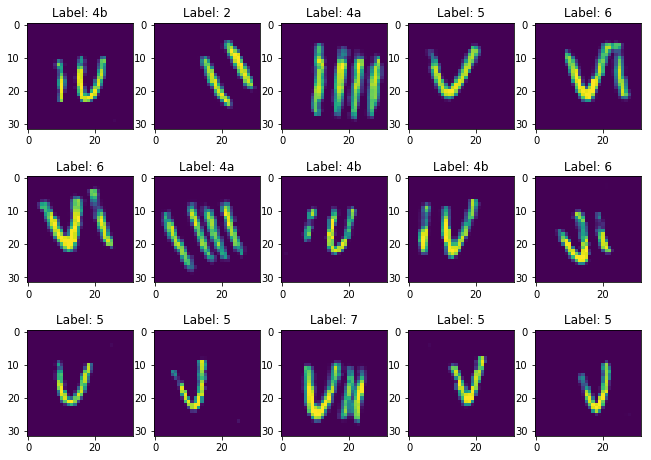

In [6]:
def loadDataset(cached = True):
  if not cached:
    img = cv2.imread("Variant2fixed4783.png", cv2.IMREAD_GRAYSCALE)
    print("Input image:", img.shape)
#     fig = plt.figure(num=1, figsize=(20, 5))
#     plt.imshow(img)

    tiles = sliceImage(img)
    print("Tiled array:", tiles.shape)

    features, labels = annotateTiles(tiles)

    # shuffle data
    permutation = np.random.permutation(range(labels.size))
    features = [features[i] for i in permutation]
    labels = [labels[i] for i in permutation]

    # split on train, devel, test
    num = len(labels)
    splits = list(map(round, [num * 0.7, num * 0.85, num])) # 0.7, 0.15, 0.15
    print("Has {} training, {} devel, {} test images".format(splits[0], splits[1] - splits[0], splits[2] - splits[1]))


    dataset = dict(
      train = (features[0:splits[0]], labels[0:splits[0]]),
      devel = (features[splits[0]:splits[1]], labels[splits[0]:splits[1]]),
      test = (features[splits[1]:splits[2]], labels[splits[1]:splits[2]]),
    )

    # augment training dataset
    train_features = []
    train_labels = []

    print("\nAugmenting training data {} folds".format(augmentation_rate))
    for i in range(splits[0]):
      train_features += augment(dataset["train"][0][i], augmentation_rate)
      train_labels += [dataset["train"][1][i]] * augmentation_rate

    # reshuffle training data
    permutation = np.random.permutation(range(len(train_labels)))
    train_features = [train_features[i] for i in permutation]
    train_labels = [train_labels[i] for i in permutation]
    print("Augmented training data contains {} samples".format(len(train_labels)))

    dataset["train"] = (train_features, train_labels)
    
    print("\nSome augmented training samples")
    fig = plt.figure(figsize = (11, 8))
    for i in range(15):
      a = fig.add_subplot(3, 5, i + 1)
      plt.imshow(train_features[i])
      a.set_title("Label: {}".format(label_map[train_labels[i]]))

    with open("dataset.pickle", "wb") as f:
      pickle.dump(dataset, f)

  with open("dataset.pickle", "rb") as f:
    dataset = pickle.load(f)

  return dataset

dataset = loadDataset(load_cached_data)

train_data = np.asarray(dataset["train"][0], dtype=np.float32) / 255
train_labels = np.asarray(dataset["train"][1], dtype=np.int32)
devel_data = np.asarray(dataset["devel"][0], dtype=np.float32) / 255
devel_labels = np.asarray(dataset["devel"][1], dtype=np.int32)
test_data = np.asarray(dataset["test"][0], dtype=np.float32) / 255
test_labels = np.asarray(dataset["test"][1], dtype=np.int32)

#### Here we define a CNN moodel to be used with `tf.estimation.Estimator`

Network has two convolution layers, and two fully-connected with dropout layer inbetween

In [7]:
def cnnModelFn(features, labels, mode):
  input_layer = tf.reshape(features["x"], [-1, imsize, imsize, 1])

  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=24,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  pool2_flat = tf.reshape(pool2, [-1, (imsize // 4) ** 2 * 32])
  dense1 = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
  dropout1 = tf.layers.dropout(inputs=dense1, rate=0.1, training=(mode == tf.estimator.ModeKeys.TRAIN))

  logits = tf.layers.dense(inputs=dropout1, units=9)

  predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  if mode == tf.estimator.ModeKeys.TRAIN:
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.00005)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

#### Some helper functions to feed data while training, inference and evaluation

In [8]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": train_data},
  y=train_labels,
  batch_size=batch_size,
  num_epochs=None,
  shuffle=True)

devel_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": devel_data},
  y=devel_labels,
  num_epochs=1,
  shuffle=False)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": test_data},
  y=test_labels,
  num_epochs=1,
  shuffle=False)

#### Create an estimator object

In [9]:
roman_classifier = tf.estimator.Estimator(model_fn=cnnModelFn, model_dir="/tmp/roman_convnet_model")

#### Finally train our network, `500` steps at a time.

Training takes about 2.5 minutes on a single Rx 580, will take a few times longer on a CPU.

`num_epochs` may be decreased to about `10`, 'coz thats the last few percent of accuracy that take most of the training time.

{'accuracy': 0.06010929, 'loss': 2.217074, 'global_step': 0}
{'accuracy': 0.8196721, 'loss': 0.50578445, 'global_step': 500}
{'accuracy': 0.9508197, 'loss': 0.18514022, 'global_step': 1000}
{'accuracy': 0.96174866, 'loss': 0.13962023, 'global_step': 1500}
{'accuracy': 0.96174866, 'loss': 0.0972427, 'global_step': 2000}
{'accuracy': 0.95628417, 'loss': 0.08929581, 'global_step': 2500}
{'accuracy': 0.96174866, 'loss': 0.08660743, 'global_step': 3000}
{'accuracy': 0.9836066, 'loss': 0.04635502, 'global_step': 3500}
{'accuracy': 0.95628417, 'loss': 0.073071495, 'global_step': 4000}
{'accuracy': 0.9781421, 'loss': 0.06244419, 'global_step': 4500}
{'accuracy': 0.9781421, 'loss': 0.04691621, 'global_step': 5000}
{'accuracy': 0.9781421, 'loss': 0.039479606, 'global_step': 5500}
{'accuracy': 0.9726776, 'loss': 0.045986526, 'global_step': 6000}
{'accuracy': 0.9726776, 'loss': 0.06506936, 'global_step': 6500}
{'accuracy': 0.9945355, 'loss': 0.013523018, 'global_step': 7000}
{'accuracy': 0.9945355

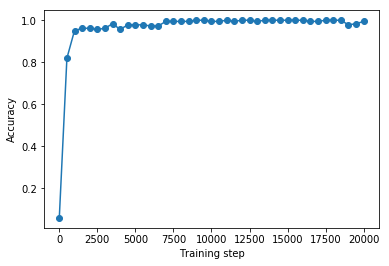

In [11]:
%%timeit -n 1 -r 1

tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

num_epochs = 40

eval_results = roman_classifier.evaluate(input_fn=devel_input_fn)
xs = [eval_results["global_step"]]
ys = [eval_results["accuracy"]]
print(eval_results)

# Train the model
for i in range(num_epochs):
  roman_classifier.train(
    input_fn=train_input_fn,
    steps=500,
    hooks=[logging_hook])
  eval_results = roman_classifier.evaluate(input_fn=devel_input_fn)
  xs.append(eval_results["global_step"])
  ys.append(eval_results["accuracy"])
  print(eval_results)

plt.plot(xs, ys, '-o')
plt.xlabel("Training step")
plt.ylabel("Accuracy")

#### Evaluate obtained accuracy:

*    plot confusion matrix
*    plot samples that were missclassified

Confusion matrix:
[[22  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0]
 [ 0  0  0 22  0  0  1  0  0]
 [ 0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0 21  0  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0 20]]
{'accuracy': 0.9945652, 'loss': 0.027267804, 'global_step': 20000}

Confused samples:


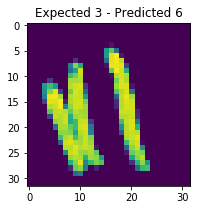

In [12]:
predicted_ids = []
predictions = roman_classifier.predict(input_fn=test_input_fn)
confused_samples = []

for pred_dict, expected, i in zip(predictions, test_labels, range(test_labels.size)):
  predicted = pred_dict['classes']
  predicted_ids.append(predicted)

  if predicted != expected:
    confused_samples.append((i, predicted, expected))

with tf.Session() as sess:
  conf_matrix_op = tf.confusion_matrix(test_labels, predicted_ids, num_classes = 9)
  conf_matrix = sess.run(conf_matrix_op)

print("Confusion matrix:")
print(conf_matrix)

eval_results = roman_classifier.evaluate(input_fn=test_input_fn)
print(eval_results)

cnum = len(confused_samples)
if cnum != 0:
  print("\nConfused samples:")
  fig = plt.figure(figsize = (10, 6 * cnum // 2))
  for i, (j, pred, exp) in enumerate(confused_samples):
    a = fig.add_subplot(cnum//2 + 1, 2, i + 1)
    plt.imshow(test_data[j])
    a.set_title("Expected {} - Predicted {}".format(label_map[exp], label_map[pred]))
else:
  print("\nClassification on evaluation dataset don't have mismatched samples")
    
  